In [1]:
import json
import numpy as np
import hnswlib
import networkx as nx
from collections import defaultdict
from tqdm.notebook import tqdm
from numpy import dot
from numpy.linalg import norm

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')
def embed(inputText):
    return model.encode(inputText)

In [2]:
import re
import string

def cosineSimilarity(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return dot(a, b)/(norm(a)*norm(b))

def l1similarity(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return 1 / ( 1+ np.linalg.norm((a - b), ord=1))

def preprocess(s):
    s = re.sub(r'\d+', '', s)
    translator = str.maketrans('', '', string.punctuation) 
    s = s.translate(translator) 
    s = s.strip()
    return s


## Reading Embeddings and creating Indexer for NN search

In [3]:
IDList = []                                # List of paper IDs
NNList = []                                # List of list, NNList[i]: NNs to paper whose id is IDList[i]
embeddings = []                            # Embeddings read from the input file
embeddingDict = dict()

#IdToTitle = dict()

with open('./data/dblp_Abstract_2Thresholded_USE_Trans_Embeddings.json', 'r') as file:
    for line in tqdm(file):
        data = json.loads(line)
        paperID = data['id']
        embedding = data['embedding']
        IDList.append(paperID)
        embeddings.append(embedding)
'''        
with open('./data/dblp_Title_2Thresholded_USE_Trans_Embeddings.json', 'r') as file:
    for line in tqdm(file):
        data = json.loads(line)
        paperID = data['id']
        embedding = data['embedding']
        embeddingDict[paperID] = embedding
'''


"        \nwith open('./data/dblp_Title_2Thresholded_USE_Trans_Embeddings.json', 'r') as file:\n    for line in tqdm(file):\n        data = json.loads(line)\n        paperID = data['id']\n        embedding = data['embedding']\n        embeddingDict[paperID] = embedding\n"

In [4]:
numElements = len(IDList)
dimension = len(embeddings[0])
embeddings = np.asarray(embeddings)
data_labels = np.arange(numElements)

In [ ]:
p = hnswlib.Index(space = 'cosine', dim = dimension) # possible options are l2, cosine or ip

# Initing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = numElements, ef_construction = 200, M = dimension)

# Element insertion (can be called several times):
p.add_items(embeddings, data_labels)

# Controlling the recall by setting ef:
p.set_ef(50) # ef should always be > k

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
labels, _ = p.knn_query(embeddings, k = 5)

In [ ]:
index_path='./models/USETranshnswlibAbstract.bin'
print("Saving index to '%s'" % index_path)
p.save_index("./models/USETranshnswlibAbstract.bin")
del p

In [ ]:
del embeddings
del data_labels

In [5]:
p = hnswlib.Index(space='cosine', dim=dimension)  # the space can be changed - keeps the data, alters the distance function.

# Increase the total capacity (max_elements), so that it will handle the new data
p.load_index("./models/USETranshnswlib.bin", max_elements = numElements)
labels, _ = p.knn_query(embeddings, k = 4)
del p
del embeddings
del data_labels

## Examples of NN obtained using the Text Embeddings

In [ ]:
titles = []
with open('./data/dblp_AIpapers2Thresholded.json', 'r') as file:
    for line in file:
        data = json.loads(line)
        titles.append(data['title'])
        paperID = data['id']
        IdToTitle[paperID] = data['title']

In [ ]:
count = 5
for i in range(count):
    print('Paper: ', titles[i])
    print('Nearest Papers: ', [titles[ind] for ind in labels[i] if ind != i])
    print('\n')

## Building Adjacency List for Node Embeddings

### Creating Citation Adjacency List

In [4]:
adjList = defaultdict(set)                          # Convert set to list later for node2vec, set: to handle duplicates
#G = nx.Graph()
with open('./data/dblp_AIpapers2Thresholded.json', 'r') as file:
    for line in tqdm(file):
        data = json.loads(line)
        paperID = data['id']
        references = data.get('references', [])
        for referencedPaper in references:
            adjList[paperID].add(referencedPaper)
            adjList[referencedPaper].add(paperID)
            #G.add_edge(paperID, referencedPaper, weight=1.0)

### Augmenting Adj List with FastText NNs

In [7]:
nnToKeep = 4
id = 0
for label in tqdm(labels):
    paperID = IDList[id]
    label = [IDList[index] for index in label if index != id]
    if (len(label) > nnToKeep):
        del label[nnToKeep:]
    for referencedPaper in label:
        adjList[paperID].add(referencedPaper)
        adjList[referencedPaper].add(paperID)
        '''
        paperID1 = paperID
        paperID2 = referencedPaper
        title1 = IdToTitle[paperID1]
        title2 = IdToTitle[paperID2]
        embeddings = embed([title1, title2])
        G.add_edge(paperID1, paperID2, weight= max(0, cosineSimilarity(embeddings[0], embeddings[1])))
        '''
    id += 1

### Creating NetworkX Graph and reporting graph statistics

In [5]:
adjList = {key: list(values) for key, values in adjList.items()}
G = nx.from_dict_of_lists(adjList)

nnodes = G.number_of_nodes()
avgDegree = sum(d for n, d in G.degree()) / float(nnodes)
print('Number of nodes: ', nnodes, '. Number of edges: ', G.number_of_edges(), '. Avg Degree: ', avgDegree)

Number of nodes:  471633 . Number of edges:  5464345 . Avg Degree:  23.172021465843144


In [9]:
## Adding edge weights
for e in tqdm(G.edges()):
    paperID1 = e[0]
    paperID2 = e[1]
    simScore = cosineSimilarity(embeddingDict[paperID1], embeddingDict[paperID2])
    if simScore <= 0:
        G.remove_edge(paperID1, paperID2)
    else:
        G[e[0]][e[1]]['weight'] = simScore

In [10]:
del embeddingDict

## Node2Vec Embeddings

In [11]:
from node2vec import Node2Vec
walkLength = 8
node2vec = Node2Vec(G, walk_length = walkLength, p = 1.5, q = 0.4, num_walks = 10)#, workers = 12, temp_folder = './data/tmp_data')
          

Computing transition probabilities:  96%|█████████▋| 459048/475839 [2:45:43<06:47, 41.18it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
model = node2vec.fit()  # returns a gensim wv model

In [13]:
outFileName = './models/node2vevWeighted.kv'
model.wv.save_word2vec_format(outFileName)

In [14]:
from gensim import models
loadModel = models.keyedvectors.KeyedVectors.load_word2vec_format('./models/node2vevWeighted.kv')

In [ ]:
titles = []
IDList = []
with open('./data/dblp_AIpapers2Thresholded.json', 'r') as file:
    for line in tqdm(file):
        data = json.loads(line)
        titles.append(data['title'])
        IDList.append(data['id'])

In [ ]:
loadModel.most_similar(IDList[10])

In [ ]:
for id, title in zip(IDList, titles):
    if (id == '1614298861'):
        print(title)
        break

In [ ]:
def ret(paperID):
    for id, title in zip(IDList, titles):
        if (id == paperID):
            return title
            

In [ ]:
[ret(id) for id, _ in loadModel.most_similar('1614298861')]

In [ ]:
[ret(id) for id in adjList['1614298861']]

In [ ]:
adjList['1614298861']

In [6]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 471633
Number of edges: 5464345
Average degree:  23.1720


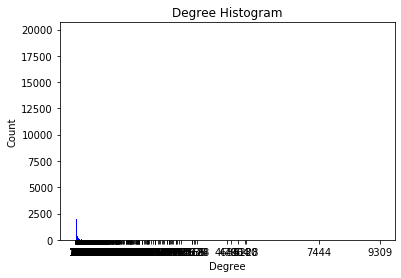

In [8]:
import collections
import matplotlib.pyplot as plt

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 10 for d in deg])
ax.set_xticklabels(deg)

plt.show()

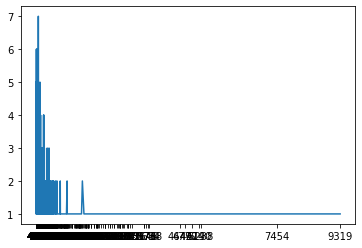

In [14]:
fig, ax = plt.subplots()
deg = deg[: 500]
cnt = cnt[:500]
plt.plot(deg, cnt)
ax.set_xticks([d + 10 for d in deg])
plt.show()